In [1]:
#! pip install torch numpy matplotlib
#! pip install torchvision
#! pip install tqdm
#! pip install opencv-python

### CNN QR Code Detector

#### Проблема

Существующий сервис принимает pdf документы A4 формата, на одной из страниц которого находится наклейка c qr-кодом. Документы сканированы с низким разрешением (72 dpi),
Наклейки могут быть наклеены как попало, но в районе нижнего левого угла. Документы сканируют на разных сканерах, и из-за этого у них может быть разный
контраст/яркость.

Для уверенного распознавания кодов, иногда требуется дополнительно обрабатывать изображение итеративно подбирая фактор гамма-коррекции и отсечку черное/белое.
Что занимает 1 - 1.5 секунды на лист.


#### Решение

Необходим детектор, который еще до стадии распознавания кода, сможет предсказать - есть ли на данном участке код или нет. Это позволит сократить время обработки
документа, так-как модуль распознавания не будет тратить время в попытке распознать код, которого нет.

Сервис высоконагружаемый и встроен в пайплайн производства, так что детектор критичен к **ложно-отрицательным** (FN) предсказаниям. Но может позволить
себе ложно-положительные (FP) срабатывания (в разумных пределах)

#### Варианты реализации

1) Использовать QR детектор из библиотеки OpenCV
2) Создать собственный детектор на базе CNN и обучить на существующих документах.

#### Преимущества разных подходов

**Плюсы OpenCV**
1) OpenCV - довольно небольшая библиотека (по сравнению с Pytorch)
2) Быстро работает, не требовательна к ресурсам

**Минусы OpenCV**
1) Как выяснилось, детектору необходимо полноценное разрешение картинки (на миниатюрах 224 * 224 пиксела фактически не видит qr-код).
2) Чувствителен к качеству изображения, т.е. сводит на нет идею использовать его до тяжеловесного процесса улучшения изображения.
3) Не может использовать многоядерность CPU

**Плюсы CNN**
1) Хорошая предсказательная способность на миниатюрах изображения (видит паттерн кода) что и требуется от детектора
2) Достаточно быстро работает в режиме предсказания, достаточно CPU, хорошо масштабирует загрузку по ядрам.

**Минусы СNN**
1) Требуется затащить внушительный фреймворк в докер-образ куба (~2 Гб) + сами веса сети (44 Mb)
2) Работает медленнее на CPU


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    roc_curve
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights
from tqdm import tqdm

In [3]:
print(torch.cuda.is_available())
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [4]:
data_dir = '/home/mech/Downloads/results/dataset_224/'

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485], [0.229])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485], [0.229])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}

data_transforms

{'train': Compose(
     Grayscale(num_output_channels=1)
     Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.5)
     RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
     ToTensor()
 ),
 'val': Compose(
     Grayscale(num_output_channels=1)
     Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.5)
     ToTensor()
 ),
 'test': Compose(
     Grayscale(num_output_channels=1)
     Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 )}

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test'] if not x.startswith('.')}

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']
              }

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test'] if not x.startswith('.')}

dataset_sizes

{'train': 5000, 'val': 1000, 'test': 6965}

In [9]:
class_names = image_datasets['train'].classes
class_names

['missed', 'qrcodes']

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [11]:
# Get a batch of training data (Получение пакета обучающих данных)
inputs, classes = next(iter(dataloaders['train']))
inputs.size()


torch.Size([128, 1, 224, 224])

In [12]:
classes

tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1])

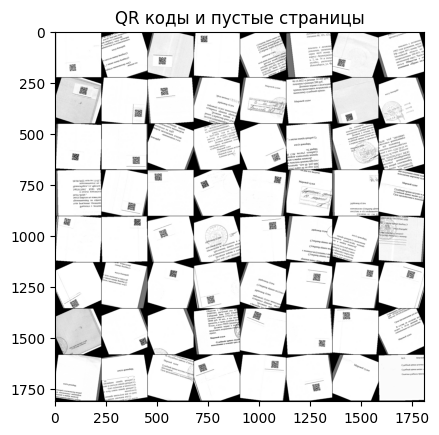

In [31]:
# Make a grid from batch (Сделать сетку из партии)
out = torchvision.utils.make_grid(inputs[:64])
imshow(out, title='QR коды и пустые страницы')

In [14]:
def train(data_loader: DataLoader, model: models.resnet18, optimizer: optim.Adam) -> None:
    
    model.train()
   
    for inputs, targets in data_loader:
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
      
        optimizer.zero_grad()
    
        outputs = model(inputs)

        loss = loss_func(outputs, targets.view(-1, 1))

        loss.backward()

        optimizer.step()

In [15]:
def evaluate(data_loader: DataLoader, model: models.resnet18, device: str = 'cpu') -> tuple:

    model.eval()

    final_targets = []
    final_outputs = []
   
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
         
            output = model(inputs)
     
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
         
            final_targets.extend(targets)
            final_outputs.extend(output)

    return final_outputs, final_targets

In [16]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCEWithLogitsLoss().to(device)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
for epoch in tqdm(range(5)):

    train(dataloaders['train'], model, optimizer)
    predictions, valid_targets = evaluate(dataloaders['val'], model, device=device)
    roc_auc = roc_auc_score(valid_targets, predictions, average='weighted')
    print(f"Epoch={epoch}, Valid ROC AUC={roc_auc}")


 20%|██        | 1/5 [00:05<00:21,  5.26s/it]

Epoch=0, Valid ROC AUC=0.859356


 40%|████      | 2/5 [00:09<00:13,  4.59s/it]

Epoch=1, Valid ROC AUC=0.999992


 60%|██████    | 3/5 [00:13<00:08,  4.38s/it]

Epoch=2, Valid ROC AUC=1.0


 80%|████████  | 4/5 [00:17<00:04,  4.29s/it]

Epoch=3, Valid ROC AUC=1.0


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]

Epoch=4, Valid ROC AUC=1.0


### Результаты CNN QR детектора для тестового датасета

In [18]:
%%time
#model.to('cpu')
predictions, test_targets = evaluate(dataloaders['test'], model, device=device)

CPU times: user 1.48 s, sys: 291 ms, total: 1.77 s
Wall time: 20.4 s


In [19]:
test_predicts = np.where(np.concatenate([np.array(i) for i in predictions]) >= 0, 1, 0)

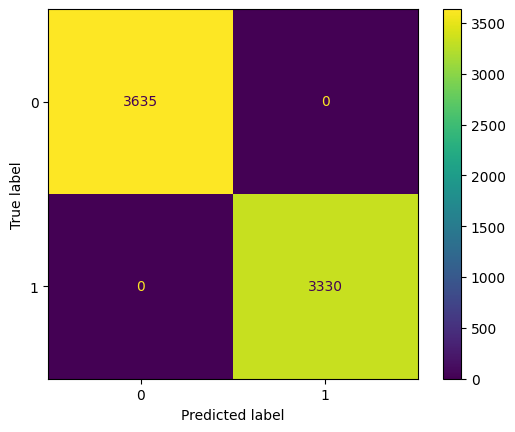

In [20]:
# Матрица ошибок
cm = confusion_matrix(test_targets, test_predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [21]:
roc_cnn_result = roc_auc_score(test_targets, test_predicts, average='weighted')
print('CNN QR Detector result', roc_cnn_result)

CNN QR Detector result 1.0


Сохранение модели для дальшейшего использования

In [22]:
# model_ft.to('cpu')
# torch.save(model_ft, 'models_bin/detector_auc.bin')
# torch.save(model_ft.state_dict(), 'models_bin/detector_auc.layers')
# model_ft.to(device)

### Результаты OpenCV QR Detector для тестового датасета

In [23]:
import cv2
from glob import glob
detector = cv2.QRCodeDetector()

In [24]:
def is_qr_exists_opencv(image):
    result = detector.detect(image)
    return result[0]

In [25]:
images_qrcodes = glob(f'{data_dir}/test/qrcodes/*.png')
images_without_qrcodes = glob(f'{data_dir}/test/missed/*.png')

In [26]:
def predict_with_opencv(files: list, label: int):
    for file in tqdm(files):
        cv_test_targets.append(label)
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        cv_predicts.append(1 if is_qr_exists_opencv(image) else 0)


In [27]:
%%time
cv_test_targets = []
cv_predicts = []
predict_with_opencv(images_qrcodes, 1)
predict_with_opencv(images_without_qrcodes, 0)

100%|██████████| 3635/3635 [02:45<00:00, 21.96it/s]

CPU times: user 7min 21s, sys: 1min 56s, total: 9min 18s
Wall time: 5min 14s


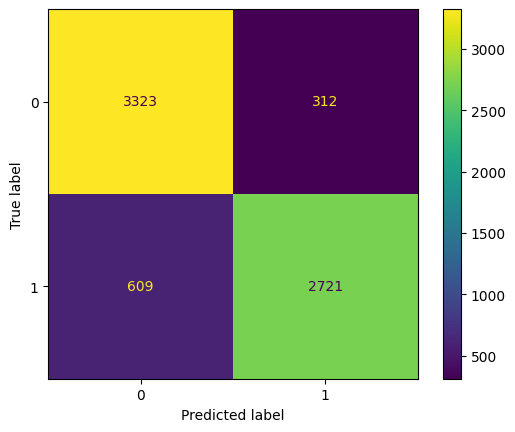

In [28]:
# Матрица ошибок
cm = confusion_matrix(cv_test_targets, cv_predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [29]:
roc_cv_result = roc_auc_score(cv_test_targets, cv_predicts, average='weighted')
print('OpenCV QR Detector result', roc_cv_result)

OpenCV QR Detector result 0.8656424650234829
